In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from setfit import AbsaModel
from IPython.core.display_functions import clear_output
from pprint import pprint
import os
from random import random
import json
import re
import yfinance as yf
import numpy as np
from numpy.linalg import norm

import torch

from sentence_transformers import SentenceTransformer



/Users/darkosegvic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/darkosegvic/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def gen_int_random_size(size):
    return int((random() * 100) % size)

def count_lines(filename):
    with open(filename, 'r') as file:
        return sum(1 for line in file)

def join_stock_symbol(text):
    return re.sub(r'\$\s+', '$', text)

def purify(text):
    text = text.replace("URL", "")
    text = text.replace("AT_USER", "")

    return text

# Function to process the file
def get_random_json_line(filename):
    line_count = count_lines(filename)

    random_number = gen_int_random_size(line_count)

    with open(filename, 'r') as file:
        for line_number, line in enumerate(file, start=0):
            if line_number != random_number:
                continue

            try:
                return json.loads(line)
            except json.JSONDecodeError:
                print(f"Error decoding JSON on line {line_number}")

def load_random_tweet():
    current_directory = os.getcwd()

    preprocessed_directory = os.path.join(current_directory + "/stocknet-dataset/tweet/preprocessed")

    directories = os.listdir(preprocessed_directory)

    random_directory = os.path.join(preprocessed_directory, directories[gen_int_random_size(len(directories))])

    files = os.listdir(random_directory)

    random_file = os.path.join(random_directory, files[gen_int_random_size(len(files))])
    # print(random_file)

    random_json_line = get_random_json_line(random_file)
    # print(random_json_line["text"])
    joined_text = " ".join(random_json_line["text"])

    return join_stock_symbol(joined_text)





In [228]:
def replace_symbols_with_names(text):
    # Regular expression to find stock symbols
    symbols = re.findall(r"\$\w+", text)
    company_symbols = []

    for symbol in symbols:
        # Remove the dollar sign for the API query
        query_symbol = symbol[1:]

        # Use a financial data API to get the company name
        company_name = get_company_name(query_symbol)

        if company_name:
            # Replace the symbol with the company name in the text
            text = text.replace(symbol, f" {company_name} ,")
            company_symbols.append({f"{query_symbol}" : company_name})

    return text, company_symbols

def get_company_name(symbol):
    try:
        stock = yf.Ticker(symbol)
        # Fetching company name
        return stock.info['longName']
    except:
        # Return None if company name not found or error occurs
        return "" 

In [4]:
polarity_model = AbsaModel.from_pretrained(
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect",
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity",
    spacy_model="en_core_web_lg",
)

`SentenceTransformer._target_device` has been removed, please use `SentenceTransformer.device` instead.
`SentenceTransformer._target_device` has been removed, please use `SentenceTransformer.device` instead.


In [5]:
# ner_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
# ner_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# nlp = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer)

# clear_output(False)

In [6]:
def join_entity_words(data):
    joined_words = []
    current_word = ""
    current_entity = None

    for i, item in enumerate(data):
        # Check if we are at the start of a new word
        if 'B-' in item['entity']:
            # Save the previous word if it exists
            if current_word:
                joined_words.append({'word': current_word, 'entity': current_entity})
            current_word = item['word']
            current_entity = item['entity']
        else:
            # Check if the current word should be appended with a space
            if not item['word'].startswith('##'):
                # Append a space if it's not the first subword
                if i > 0 and not data[i - 1]['word'].endswith('##'):
                    current_word += ' '
            current_word += item['word'].replace('##', '')

    # Add the last word
    if current_word:
        joined_words.append({'word': current_word, 'entity': current_entity})

    return joined_words

In [144]:
text_comparison_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_embedding(text):
    sentences = [text]
    embeddings = text_comparison_model.encode(sentences)
    return embeddings

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def vector_comparison(first_entity, second_entity):
    first_vector_entity = get_embedding(first_entity)[0]
    second_vector_entity = get_embedding(second_entity)[0]

    return cosine_similarity(first_vector_entity, second_vector_entity)

def replace_polarity(data):
    polarity_map = {'negative': -1, 'neutral': 0, 'positive': 1}

    for item_list in data:
        for item in item_list:
            if item['polarity'] in polarity_map:
                item['polarity'] = polarity_map[item['polarity']]

    return data

# Function to find the best match for a span
def find_best_match(span, comparison_data):
    if span in comparison_data:
        # Sort the dictionary by values and return the key with the highest value
        return max(comparison_data[span], key=comparison_data[span].get)
    return span  # Return the original span if no match is found


In [174]:
def get_entity_company_matches(polarity_predictions, companies):
    entity_company_matches = {}

    for pred in polarity_predictions:
        for prediction in pred:
            entity_company_matches[f"{prediction['span']}"] = []
            for company in companies:
                company_value = (list(company.values()))[0]
                # print("Company value: ", company_value)
                entity_company_matches[f"{prediction['span']}"].append({f"{company_value}": vector_comparison(company_value, prediction['span'])})
                # item1 = f"ENTITY: {prediction['span']} -  "
                # item2 = f"COMPANY: {company} -> "
                # print(f"{item1:<50}",f"{item2:<50}", vector_comparison(company, prediction['span']))
    
    return entity_company_matches


def get_entity_company_thresholded(entity_company_matches, similarity_threshold):
    entity_company_thresholded = {}

    for key in entity_company_matches.keys():
        entity_company_thresholded[f"{key}"] = []
        for item in entity_company_matches[f"{key}"]:
            for k, v in item.items():
                if v > similarity_threshold:
                    entity_company_thresholded[f"{key}"].append({f"{k}": v})
    return entity_company_thresholded

def get_max_vector_similarity(entity_company_pairs):
    entity_company_maxscore = {}
    
    for key, value_list in entity_company_pairs.items():
        if value_list:  # Check if the list is not empty
            max_score = max(value_list, key=lambda x: list(x.values())[0])
            entity_company_maxscore[key] = max_score
    
    return entity_company_maxscore

def replace_polarity_spans_with_companies(polarity_predictions, entity_company_matches):
    new_predictions = []

    # Iterate over the original predictions and create new modified ones
    for prediction in polarity_predictions:
        new_prediction = []
        for item in prediction:
            # Create a new dictionary with the same keys and updated span
            new_item = {key: value for key, value in item.items()}
            new_item['span'] = find_best_match(new_item['span'], entity_company_matches)
            new_prediction.append(new_item)
        new_predictions.append(new_prediction)

    return new_predictions

def average_polarity_prediction(data):
    # Initialize a dictionary to store the sum and count of polarities for each span
    polarity_sums = {}
    polarity_counts = {}

    # Iterate over each item in the list of dictionaries
    for item in data[0]:
        span = item['span']
        polarity = item['polarity']
        
        # Update the sum and count for each span
        if span in polarity_sums:
            polarity_sums[span] += polarity
            polarity_counts[span] += 1
        else:
            polarity_sums[span] = polarity
            polarity_counts[span] = 1

    # Calculate the average polarity for each span
    averaged_data = []
    for span in polarity_sums:
        avg_polarity = polarity_sums[span] / polarity_counts[span]
        averaged_data.append({'polarity': avg_polarity, 'span': span})

    # Wrap the result in a list
    result = [averaged_data]
    return result



In [9]:
random_tweet = load_random_tweet()
print(200*"=")
print("Random Tweet :")
print(random_tweet)
random_tweet_purified = purify(random_tweet)
print(random_tweet_purified)
print(200*"=")

random_example_symbols_replaced, companies = replace_symbols_with_names(random_tweet_purified)
print(random_example_symbols_replaced)

print(200*"=")


# NER_results = nlp(random_example_symbols_replaced)
# for item in NER_results:
#     pprint(item['entity'] + " " + item['word'])

# pprint(join_entity_words(NER_results))

sentences = [random_example_symbols_replaced]
polarity_predictions = polarity_model.predict(sentences)
polarity_predictions = replace_polarity(polarity_predictions)


print(200*"=")
print("Predictions")
print(200*"=")
for v1, v2 in zip(sentences, polarity_predictions):
    pprint(v1)
    for item in v2:
        print(item)


Random Tweet :
abb gapped up +0.22 $abb last price 18.81 day high 18.83 day low 18.81 change +0.30 volume 121,956 today 31 st URL
abb gapped up +0.22 $abb last price 18.81 day high 18.83 day low 18.81 change +0.30 volume 121,956 today 31 st 
abb gapped up +0.22 $abb last price 18.81 day high 18.83 day low 18.81 change +0.30 volume 121,956 today 31 st 
Predictions
('abb gapped up +0.22 $abb last price 18.81 day high 18.83 day low 18.81 '
 'change +0.30 volume 121,956 today 31 st ')
{'span': 'abb', 'polarity': 1}
{'span': '+0.22', 'polarity': 0}
{'span': 'abb', 'polarity': 1}
{'span': 'price', 'polarity': 1}
{'span': 'day', 'polarity': 0}
{'span': 'day low', 'polarity': 0}
{'span': 'change +0.30', 'polarity': -1}
{'span': 'today', 'polarity': 1}
{'span': 'st', 'polarity': 1}


In [10]:
entity_company_matches = get_entity_company_matches(polarity_predictions, companies)
pprint(entity_company_matches)

similarity_threshold = 0.2

entity_company_thresholded = get_entity_company_thresholded(entity_company_matches, similarity_threshold)
print("Filtered data: ")
pprint(entity_company_thresholded)



{'+0.22': [],
 'abb': [],
 'change +0.30': [],
 'day': [],
 'day low': [],
 'price': [],
 'st': [],
 'today': []}
Filtered data: 
{'+0.22': [],
 'abb': [],
 'change +0.30': [],
 'day': [],
 'day low': [],
 'price': [],
 'st': [],
 'today': []}


In [11]:
entity_company_maxscore = get_max_vector_similarity(entity_company_thresholded)
pprint(entity_company_maxscore)

{}


In [12]:
pprint(sentences)
print(50*"=")
print("Polarity predictions")
pprint(polarity_predictions)
print(50*"=")
print("Spans and Company comparisons")
pprint(entity_company_maxscore)

['abb gapped up +0.22 $abb last price 18.81 day high 18.83 day low 18.81 '
 'change +0.30 volume 121,956 today 31 st ']
Polarity predictions
[[{'polarity': 1, 'span': 'abb'},
  {'polarity': 0, 'span': '+0.22'},
  {'polarity': 1, 'span': 'abb'},
  {'polarity': 1, 'span': 'price'},
  {'polarity': 0, 'span': 'day'},
  {'polarity': 0, 'span': 'day low'},
  {'polarity': -1, 'span': 'change +0.30'},
  {'polarity': 1, 'span': 'today'},
  {'polarity': 1, 'span': 'st'}]]
Spans and Company comparisons
{}


In [13]:
company_polarities = replace_polarity_spans_with_companies(polarity_predictions, entity_company_maxscore)
pprint(company_polarities)

[[{'polarity': 1, 'span': 'abb'},
  {'polarity': 0, 'span': '+0.22'},
  {'polarity': 1, 'span': 'abb'},
  {'polarity': 1, 'span': 'price'},
  {'polarity': 0, 'span': 'day'},
  {'polarity': 0, 'span': 'day low'},
  {'polarity': -1, 'span': 'change +0.30'},
  {'polarity': 1, 'span': 'today'},
  {'polarity': 1, 'span': 'st'}]]


In [14]:
print(average_polarity_prediction(company_polarities))

[[{'polarity': 1.0, 'span': 'abb'}, {'polarity': 0.0, 'span': '+0.22'}, {'polarity': 1.0, 'span': 'price'}, {'polarity': 0.0, 'span': 'day'}, {'polarity': 0.0, 'span': 'day low'}, {'polarity': -1.0, 'span': 'change +0.30'}, {'polarity': 1.0, 'span': 'today'}, {'polarity': 1.0, 'span': 'st'}]]


In [ ]:
import networkx as nx
from itertools import combinations

def update_graph(graph, companies):
    # Iterate over all possible pairs of companies
    for company1, company2 in combinations(companies, 2):
        # Ensure both companies are nodes in the graph
        if not graph.has_node(company1):
            graph.add_node(company1)
        if not graph.has_node(company2):
            graph.add_node(company2)

        # If an edge already exists, increment the 'mention' attribute
        if graph.has_edge(company1, company2):
            graph[company1][company2]['mention'] += 1
        else:
            # Otherwise, add a new edge with 'mention' set to 1
            graph.add_edge(company1, company2, mention=1)

G = nx.Graph()

for i in range (0, 500):
    random_tweet = load_random_tweet()
    random_tweet_purified = purify(random_tweet)
    random_example_symbols_replaced, companies = replace_symbols_with_names(random_tweet_purified)
    print(i)
    
    # pprint(companies)
    update_graph(G, companies)

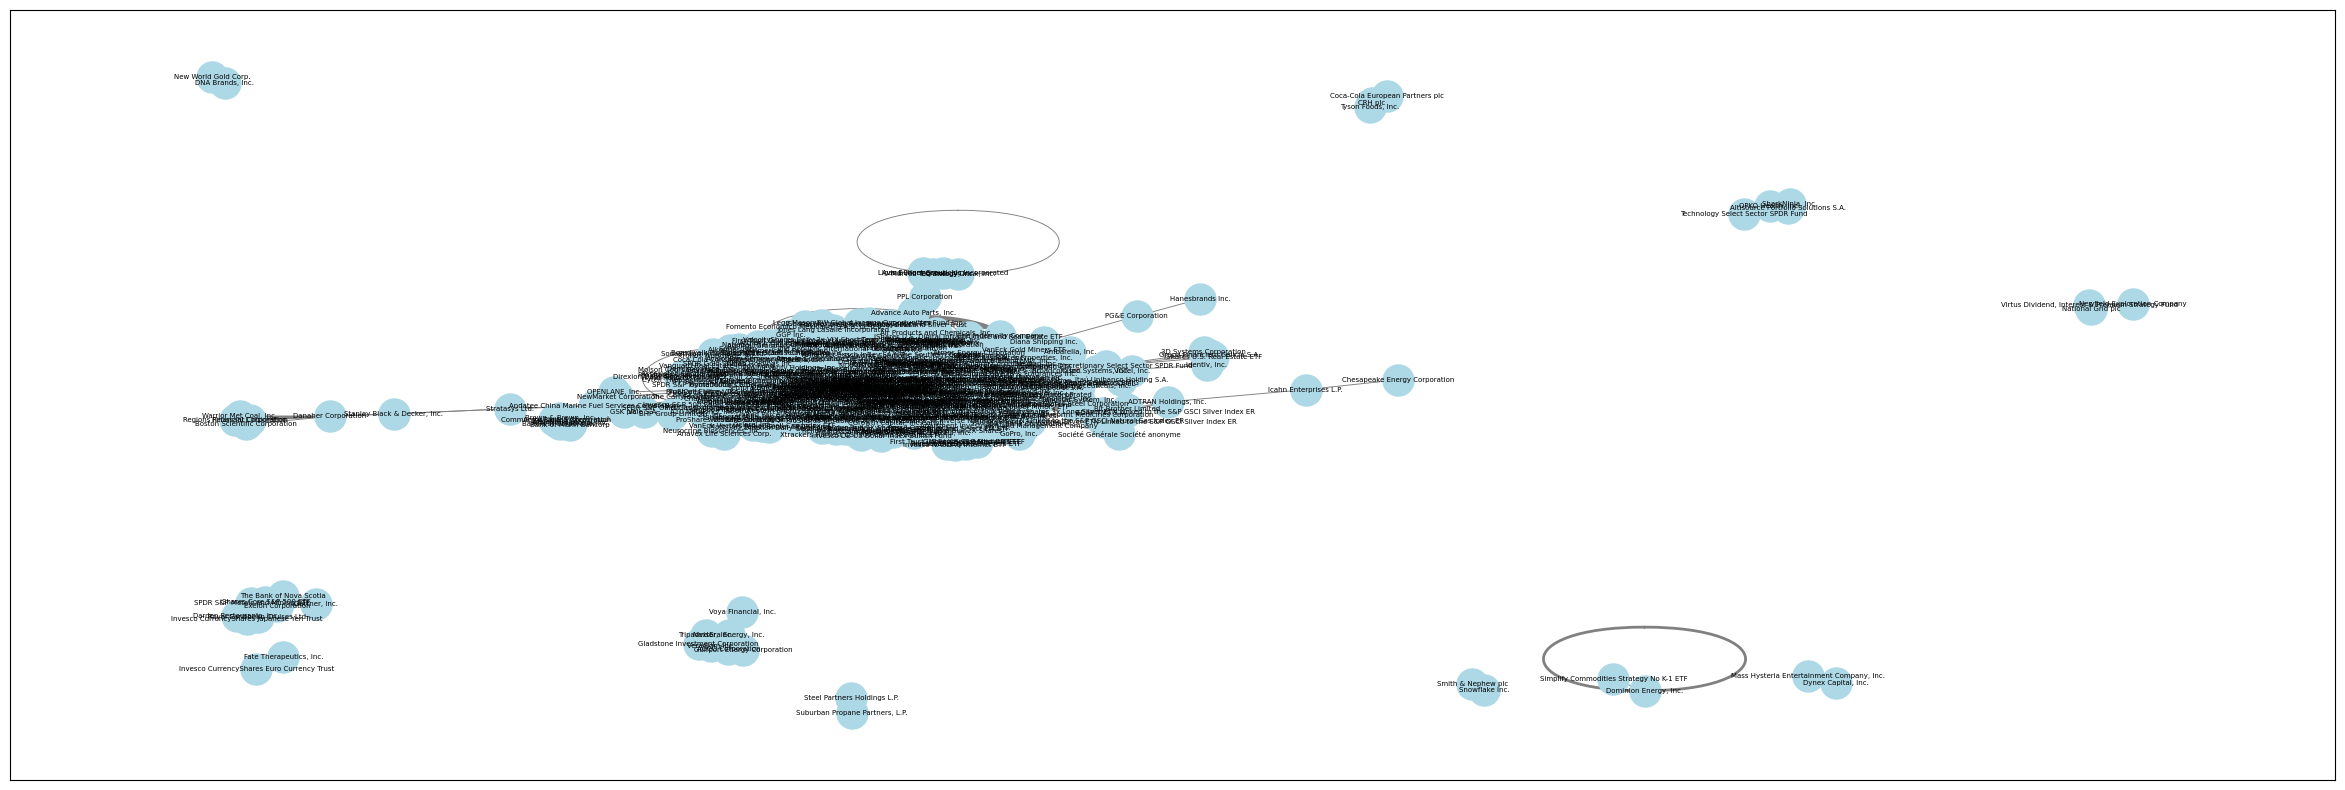

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your graph

# Extract edge 'mention' attributes into a list
edge_mentions = [G[u][v]['mention'] for u, v in G.edges()]

# Normalize edge mentions for better visualization
max_mention = max(edge_mentions)
edge_widths = [mention / max_mention * 10 for mention in edge_mentions]  # Scale for visibility

plt.figure(figsize=(30, 10))  # Increase the size as needed

# Draw the graph
pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, font_size=5)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')

plt.show()

plt.savefig('network_graph.png', format='jpg', dpi=300)  # Increase DPI as needed


In [82]:
import networkx as nx
from itertools import combinations

def update_graph(graph, companies):
    # Iterate over all possible pairs of companies
    for company1, company2 in combinations(companies, 2):
        if company1 == company2:
            continue
        # Ensure both companies are nodes in the graph
        if not graph.has_node(company1):
            graph.add_node(company1)
        if not graph.has_node(company2):
            graph.add_node(company2)

        # If an edge already exists, increment the 'mention' attribute
        if graph.has_edge(company1, company2):
            graph[company1][company2]['mention'] += 1
        else:
            # Otherwise, add a new edge with 'mention' set to 1
            graph.add_edge(company1, company2, mention=1)

In [246]:
def get_polarity_by_span(data, span):
    polarity = None
    for hier1 in data:
        for hier2 in hier1:
            if hier2.get('span') == span:
                # Retrieve the polarity value
                polarity = hier2.get('polarity')
    
    return polarity

In [247]:
def load_tweets_for_date(file, symbol):
    # tweets_list = []
    # companies_list = []
    pprint(file)

    main_company = get_company_name(symbol)

    polarity_score = 0
    polarity_count = 0

    with open(file, 'r') as file:
        for line_number, line in enumerate(file, start=0):
            try:
                tweet = json.loads(line)
                joined_tweet_text = " ".join(tweet["text"])
                stock_symbol_tweet = join_stock_symbol(joined_tweet_text)
                purified_tweet = purify(stock_symbol_tweet)

                named_companies_tweet, companies = replace_symbols_with_names(purified_tweet)

                companies_list = [list(company.values())[0] for company in companies]
                update_graph(G, companies_list)

                # print(50*"=")
                # print("Named Companies Tweet: ")
                # pprint(named_companies_tweet)


                # print(50*"=")
                sentences = [named_companies_tweet]
                polarity_predictions = polarity_model.predict(sentences)
                polarity_predictions = replace_polarity(polarity_predictions)
                # print("Polarity Predictions: ")
                # pprint(polarity_predictions)

                # print(50*"=")
                entity_company_matches = get_entity_company_matches(polarity_predictions, companies)
                # print("Entity Company matches: ")
                # pprint(entity_company_matches)

                similarity_threshold = 0.5
                
                # print(50*"=")
                entity_company_thresholded = get_entity_company_thresholded(entity_company_matches, similarity_threshold)
                # print("Thresholded data: ")
                # pprint(entity_company_thresholded)

                # print(50*"=")
                entity_company_maxscore = get_max_vector_similarity(entity_company_thresholded)
                # print("MaxScore data: ")
                # pprint(entity_company_maxscore)

                # print(50*"=")
                company_polarities = replace_polarity_spans_with_companies(polarity_predictions, entity_company_maxscore)
                # print("Company Polarities: ")
                # pprint(company_polarities)

                averaged_out_company_polarities = average_polarity_prediction(company_polarities) 
                # print("Average Company Polarities: ")
                # pprint(averaged_out_company_polarities)

                # print("Main Company polarity score")
                single_polarity_score = get_polarity_by_span(averaged_out_company_polarities,f"{main_company}")
                if single_polarity_score:
                    polarity_score += single_polarity_score
                    polarity_count += 1

                # tweets_list.append(named_companies_tweet)
                # companies_list.append(companies)
            except json.JSONDecodeError:
                print(f"Error decoding JSON on line {line_number}")
            

    main_company_polarity_score = polarity_score / polarity_count if polarity_count != 0 else 0
    print("main_company_polarity_score")
    print(main_company_polarity_score)

    return 
    # return {"tweets": tweets_list, "companies": companies_list}

def load_random_symbol_n_dates_tweets(size):
    current_directory = os.getcwd()

    preprocessed_directory = os.path.join(current_directory + "/stocknet-dataset/tweet/preprocessed")

    directories = os.listdir(preprocessed_directory)

    random_symbol = directories[gen_int_random_size(len(directories))]
    # random_symbol = "SPLP"

    random_directory = os.path.join(preprocessed_directory, random_symbol)

    # dates_tweets_companies = {}

    files = sorted(os.listdir(random_directory))
    pprint(random_directory)

    for counter, file in enumerate(files, start = 1):

        filename = os.path.join(random_directory,file)
        
        # dates_tweets_companies[file] = load_tweets_for_date(filename, random_symbol)
        load_tweets_for_date(filename, random_symbol)

        print(50*"=")
        if (counter == size):
            break
    
    # return dates_tweets_companies, random_symbol
    return random_symbol

In [248]:
G = nx.Graph()

# dates_tweets_companies, symbol = load_random_symbol_n_dates_tweets(1)
symbol = load_random_symbol_n_dates_tweets(100)
pprint(symbol)


'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ'
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-01-03'
Named Companies Tweet: 
('weekly dow stocks trend  The Walt Disney Company ,  Walmart Inc. ,  The Home '
 'Depot, Inc. ,  The Goldman Sachs Group, Inc. ,  Visa Inc. ,  Intel '
 'Corporation ,  International Business Machines Corporation , $utx  Visa Inc. '
 ',z  UnitedHealth Group Incorporated ,  AT&T Inc. ,  Microsoft Corporation ,  '
 'American Express Company ,  JPMorgan Chase & Co. ,  Merck & Co., Inc. ,  '
 'Cisco Systems, Inc. ,  The Coca-Cola Company ,  Chevron Corporation , @ ')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'dow stocks'},
  {'polarity': 1.0, 'span': 'The Walt Disney Company'},
  {'polarity': 1.0, 'span': 'Walmart Inc.'},
  {'polarity': 1.0, 'span': 'The Home Depot, Inc.'},
  {'polarity': 1.0, 'span': 'The Goldma

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/7?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=7&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('at & t inc . : at & t sees $7.6 billion gain on pension accounting   AT&T '
 'Inc. ,  Verizon Communications Inc. ,')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'AT&T Inc.'},
  {'polarity': 1.0, 'span': 't'},
  {'polarity': 1.0, 'span': 'gain'},
  {'polarity': 1.0, 'span': 'pension accounting'},
  {'polarity': 1.0, 'span': 'Verizon Communications Inc.'}]]
main_company_polarity_score
0.5
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-01-23'
Named Companies Tweet: 
('largest open interest increases among single stock options for 1/23 include  '
 'Mastercard Incorporated , , $bbry ,  eBay Inc. , ,  Verizon Communications '
 'Inc. , , and  Alcoa Corporation , .')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'interest increases'},
  {'polarity': 1.0, 'span': 'stock options'},
  {'polarity': 1.0, 'span': 'Mastercard Incorporated'}]]
Named Companies Tweet: 
('rt  too ma

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/300?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=300&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('cons . sales est . for  Infinera Corporation , q4 r ↓ $300,000 ( 0.22 % ) in '
 'last 90 days ; stk is down 40 % , bulk since jefferies note re loss of  '
 'Verizon Communications Inc. , biz . contd')
Average Company Polarities: 
[[{'polarity': -1.0, 'span': 'sales'}]]
main_company_polarity_score
0
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-01-30'
Named Companies Tweet: 
('ap technology newsbrief at 3:17 p . m . est   Apple Inc. ,  VMware, Inc. ,  '
 'Verizon Communications Inc. ,  Intel Corporation ,')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Apple Inc.'},
  {'polarity': 1.0, 'span': 'VMware, Inc.'}]]
main_company_polarity_score
0
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-02-04'
Named Companies Tweet: 
(' Verizon Communications Inc. , broadcaster fees seen surviving aereo court '
 'win ')
A

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AVID?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AVID&crumb=Rg6REg5sfh2
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HTWO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HTWO&crumb=Rg6REg5sfh2
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ESTE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ESTE&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('rt  feb 24 unusual volume : $sjf $avid  Dynasil Corporation of America ,  '
 'Kimco Realty Corporation ,  Elbit Imaging Ltd. , $tdx $htwo $cldn  Verizon '
 'Communications Inc. ,  First Trust Energy AlphaDEX Fund ,  ProShares '
 'Investment Grade—Interest Rate Hedged ,  PGIM Ultra Short Bond ETF ,  '
 'iShares U.S. Energy ETF , $tqnt $rbpaa $este')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'First Trust Energy AlphaDEX Fund'},
  {'polarity': 1.0, 'span': 'ProShares Investment Grade—Interest Rate Hedged'},
  {'polarity': 1.0, 'span': 'PGIM Ultra Short Bond ETF'},
  {'polarity': 1.0, 'span': 'iShares U.S. Energy ETF'}]]
Named Companies Tweet: 
' Verizon Communications Inc. , interesting october stock options for vz '
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 1.0, 'span': 'october stock options'},
  {'polarity': 1.0, 'span': 'vz'}]]
main_company_polarity_score
1.0
'/Users/darkosegvic/Pers

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NCR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NCR&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('pennystock research on $ncr  Ashland Inc. ,  Verizon Communications Inc. ,  '
 'Conagra Brands, Inc. , view now ')
Average Company Polarities: 
[[]]
main_company_polarity_score
0.0
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-03-12'
Named Companies Tweet: 
(' Verizon Communications Inc. , dupont becomes 2 most shorted dow stock , '
 'replacing verizon ... ')
Average Company Polarities: 
[[{'polarity': -1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': -1.0, 'span': 'dupont'},
  {'polarity': -1.0, 'span': 'dow stock'}]]
Named Companies Tweet: 
('djia - top losers :  The Coca-Cola Company , 38.38 -1.10 %  The Boeing '
 'Company , 124.48 -0.95 %  The Home Depot, Inc. , 80.63 -0.82 %  Verizon '
 'Communications Inc. , 46.37 -0.72 %  American Express Company , 92.62 -0.63 '
 '%')
Average Company Polarities: 
[[{'polarity': -1.0, 'span': 'djia'},
  {'polarity': -1.0, 'span': 'The Co

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/336?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=336&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('verizon communications : invested more than $336 million in west central '
 'florida & rsquo ; s wireline telecommu ...   Verizon Communications Inc. ,')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 1.0, 'span': 'wireline telecommu'}]]
main_company_polarity_score
1.0
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-03-19'
Named Companies Tweet: 
(' Akamai Technologies, Inc. , current price  Akamai Technologies, Inc. , most '
 'recent stock chart and technical analysis .  Chevron Corporation ,  Verizon '
 'Communications Inc. , $xiv  Agios Pharmaceuticals, Inc. ,  Walmart Inc. ,  '
 'Bank of America Corporation , http ')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Akamai Technologies, Inc.'},
  {'polarity': 1.0, 'span': 'Walmart Inc.'},
  {'polarity': 1.0, 'span': 'price'},
  {'polarity': 1.0, 'span': 'stock chart'},
  

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/437?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=437&crumb=Rg6REg5sfh2


Named Companies Tweet: 
(' Verizon Communications Inc. , verizon invested more than $437 million in '
 "pennsylvania's wireline telecommunications infrastructure in 2013 ")
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 1.0, 'span': 'wireline telecommunications infrastructure'}]]
main_company_polarity_score
1.0
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-03-21'
Named Companies Tweet: 
('  Verizon Communications Inc. , nearing 52 week low . is it a buy ? '
 'getrichcarefully')
Average Company Polarities: 
[[{'polarity': -1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 0.0, 'span': 'buy'}]]
Named Companies Tweet: 
(' Fifth Third Bancorp , on watch  Verizon Communications Inc. ,  Occidental '
 'Petroleum Corporation ,  AT&T Inc. ,  Fox Corporation ,  Cisco Systems, Inc. '
 ', ')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Fifth Thir

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GTAT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GTAT&crumb=Rg6REg5sfh2


Named Companies Tweet: 
(' AeroVironment, Inc. , dd : wasp uas / #drone   Alphabet Inc. , $gtat $fb  '
 'The Boeing Company ,  Tesla, Inc. ,  Apple Inc. ,  Amazon.com, Inc. ,  '
 'Herbalife Ltd. ,  Verizon Communications Inc. ,  HP Inc. ,  Netflix, Inc. ,  '
 'The Boeing Company ,c  General Electric Company ,  Verizon Communications '
 'Inc. ,  Alcoa Corporation ,  Microsoft Corporation ,  Plug Power Inc. ,')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'AeroVironment, Inc.'},
  {'polarity': 1.0, 'span': 'wasp uas'},
  {'polarity': 1.0, 'span': 'drone'},
  {'polarity': 1.0, 'span': 'Alphabet Inc.'},
  {'polarity': 1.0, 'span': 'The Boeing Company'},
  {'polarity': 1.0, 'span': 'Tesla, Inc.'},
  {'polarity': 1.0, 'span': 'Apple Inc.'},
  {'polarity': 1.0, 'span': 'Amazon.com, Inc.'},
  {'polarity': 1.0, 'span': 'Herbalife Ltd.'},
  {'polarity': 1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 1.0, 'span': 'HP Inc.'},
  {'polarity': 1.0, 'span': 'Netflix, Inc.'},
 

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BLAP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BLAP&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('early movers : $wmhi  IQ Healthy Hearts ETF ,  Orion Diversified Holding Co. '
 'Inc. ,  Hemp, Inc ,  The Coca-Cola Company ,  Amarantus BioScience Holdings, '
 'Inc. ,  iShares Gold Trust ,  Verizon Communications Inc. ,  Fortitude '
 'Group, Inc. , $blap  Apple Inc. , $sgms  General Motors Company ,  Federal '
 'National Mortgage Association ,  Morgan Group Holding Co. , $aol $gg  '
 'Newmont Corporation ,  Barrick Gold Corporation , $fb  IAMGOLD Corporation '
 ',  Netflix, Inc. ,  3M Company ,')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'movers'},
  {'polarity': 1.0, 'span': 'IQ Healthy Hearts ETF'},
  {'polarity': 1.0, 'span': 'Hemp, Inc'},
  {'polarity': 1.0, 'span': 'Apple Inc.'}]]
Named Companies Tweet: 
('some stocks to watch  United Rentals, Inc. ,  Verizon Communications Inc. ,  '
 'SBA Communications Corporation ,  Cleveland-Cliffs Inc. , view now ')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'stocks'},
  {'polarity': 1.

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/44?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=44&crumb=Rg6REg5sfh2
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/35?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=35&crumb=Rg6REg5sfh2
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/30?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=30&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('added to my  Verizon Communications Inc. , put ladder . added jun $44 jan 15 '
 '$35 and jan 16 $30 .')
Average Company Polarities: 
[[{'polarity': 0.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 0.0, 'span': 'ladder'}]]
Named Companies Tweet: 
(' Verizon Communications Inc. , received a new alert . find out why at  '
 'stocks daytrading trading mkt nyse nasdaq markets 311')
Average Company Polarities: 
[[{'polarity': 0.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 0.0, 'span': 'stocks'},
  {'polarity': 0.0, 'span': 'mkt nyse nasdaq markets'}]]
Named Companies Tweet: 
('rt   Verizon Communications Inc. , trading lower today as reported '
 'lower-than-expected earnings and fewer net additions in its postpaid '
 'segment ')
Average Company Polarities: 
[[{'polarity': -1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': -1.0, 'span': 'earnings'}]]
Named Companies Tweet: 
' Verizon Communications Inc. , [ $$] subscriptions boost ver

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/40?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=40&crumb=Rg6REg5sfh2


Named Companies Tweet: 
('why $chl ,  AT&T Inc. , ,  Verizon Communications Inc. , have problems . '
 'competing on price is a race to 0 . hard to have margins at $40 / mo taxes '
 'included . ')
Average Company Polarities: 
[[{'polarity': -1.0, 'span': 'chl'},
  {'polarity': -1.0, 'span': 'AT&T Inc.'},
  {'polarity': -1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 0.0, 'span': 'price'},
  {'polarity': -1.0, 'span': 'margins'},
  {'polarity': 1.0, 'span': 'mo taxes'}]]
Named Companies Tweet: 
(' Verizon Communications Inc. , : verizon reports fifth consecutive quarter '
 'of double-digit operating in ... ')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 1.0, 'span': 'quarter'}]]
main_company_polarity_score
0.3333333333333333
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-04-26'
Named Companies Tweet: 
'$hrc are you investing in $zmh  Verizon Com

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/528M?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=528M&crumb=Rg6REg5sfh2


Named Companies Tweet: 
(' Verizon Communications Inc. , up afterhours to  Unopened Box ,.70 as '
 'berkshire shows stake of $528m —  warrenbuffett verizon')
Average Company Polarities: 
[[{'polarity': 0.5, 'span': 'Verizon Communications Inc.'},
  {'polarity': 0.0, 'span': 'Unopened Box'}]]
Named Companies Tweet: 
(' Verizon Communications Inc. , new charter gets midwest ; comcast keeps n . '
 'y . , calif . ')
Average Company Polarities: 
[[{'polarity': 0.5, 'span': 'Verizon Communications Inc.'},
  {'polarity': 1.0, 'span': 'charter'}]]
main_company_polarity_score
0.6666666666666666
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-05-16'
Named Companies Tweet: 
('rt  billionaire bets : icahn ups the apple ante while buffett tagets verizon '
 ':   Verizon Communications Inc. ,  Apple Inc. ,')
Average Company Polarities: 
[[{'polarity': 1.0, 'span': 'billionaire bets'},
  {'polarity': 1.0, 'span': 'icahn ups'},
  {

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ES_F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ES_F&crumb=Rg6REg5sfh2
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NQ_F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NQ_F&crumb=Rg6REg5sfh2


Named Companies Tweet: 
("this week's write up , looking at $es_f , $nq_f ,  Biogen Inc. , , $fb ,  "
 'Apple Inc. , ,  Amgen Inc. , ,  Verizon Communications Inc. , , $mon ,  P10, '
 'Inc. , ,  United Parcel Service, Inc. , ')
Average Company Polarities: 
[[]]
main_company_polarity_score
0
'/Users/darkosegvic/PersonalDevelopment/stocknet/semantic-sentiment-analyst/stocknet-dataset/tweet/preprocessed/VZ/2014-05-20'
Named Companies Tweet: 
('verizon communications : u . s . cellular announces lower prices on shared '
 'connect plans   Verizon Communications Inc. ,')
Average Company Polarities: 
[[{'polarity': 0.0, 'span': 'Verizon Communications Inc.'},
  {'polarity': 0.0, 'span': 'u'},
  {'polarity': -1.0, 'span': 'cellular'},
  {'polarity': 0.0, 'span': 'prices'},
  {'polarity': 0.0, 'span': 'connect plans'}]]
Named Companies Tweet: 
("verizon's ceo says company not in merger talks with dish network ; focused "
 'on online streaming .  DISH Network Corporation , down 1.8 % pre mkt ,  

In [197]:
# for date in dates_tweets_companies.values():
#     companies_list = date["companies"]
#     for companies_2 in companies_list:
#         companies = [list(d.values())[0] for d in companies_2]
#         # pprint(companies)
#         update_graph(G, companies)

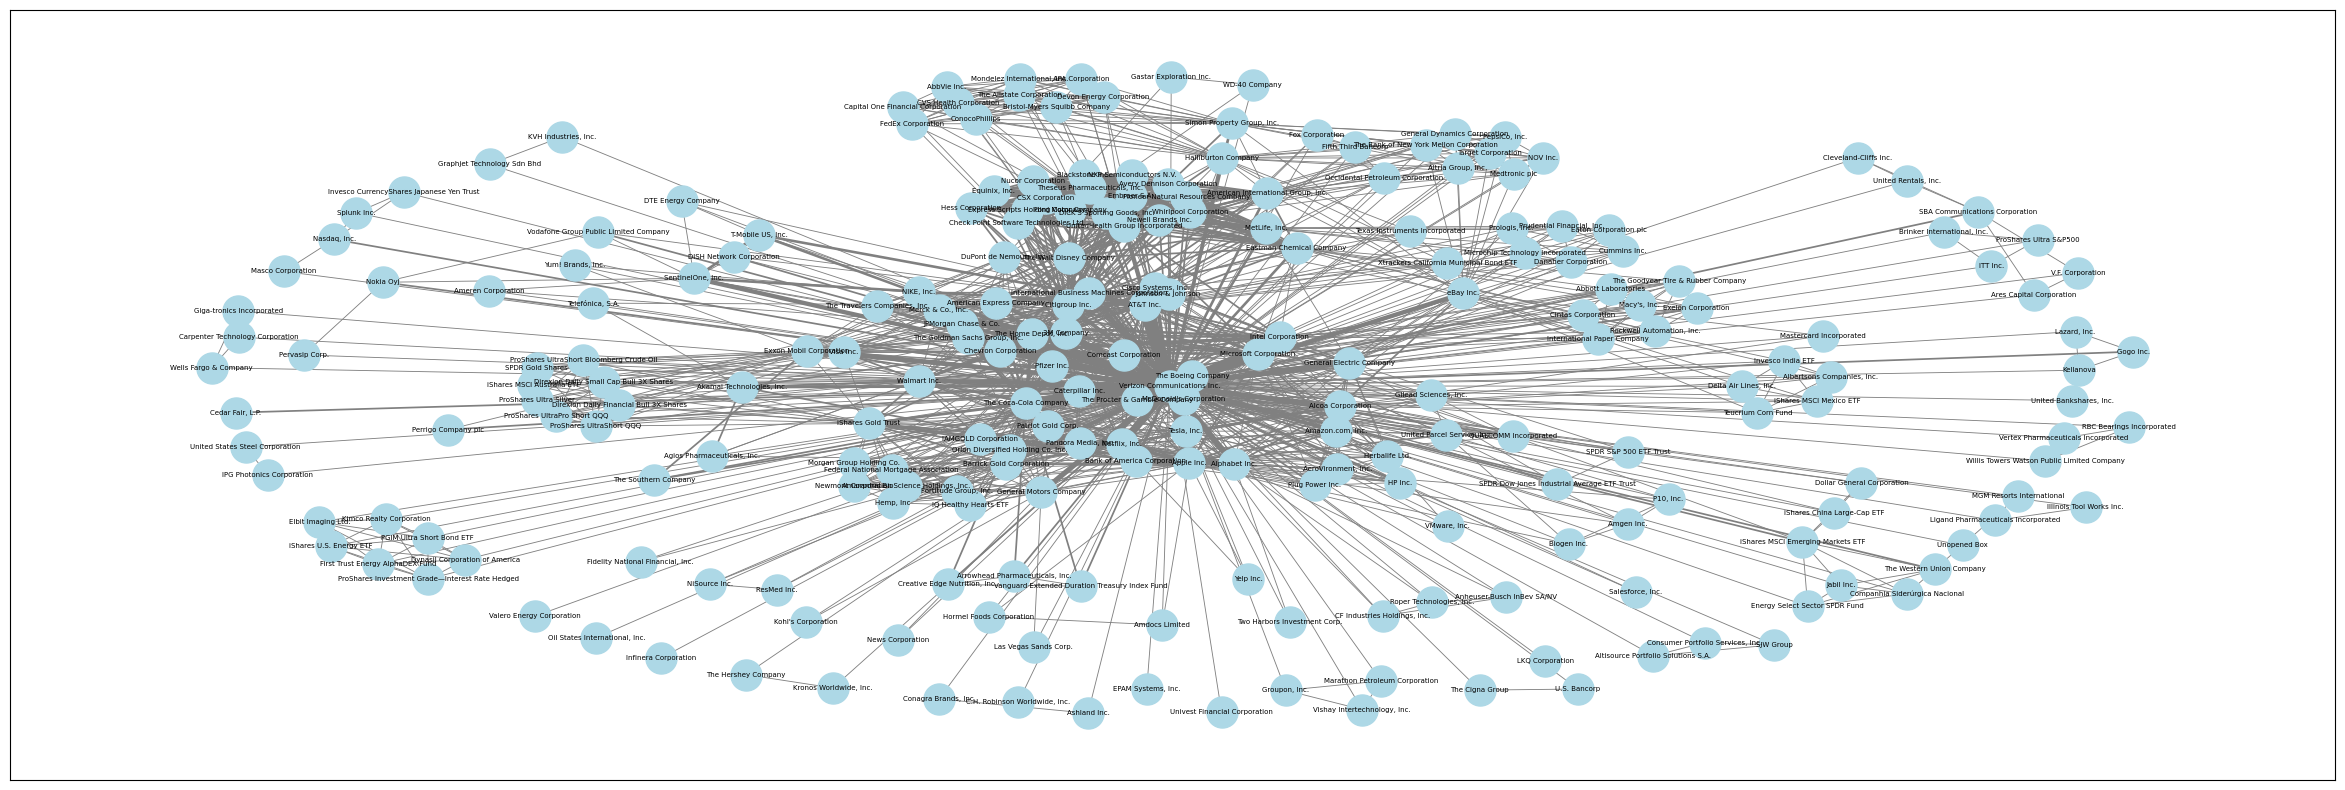

In [249]:
import matplotlib.pyplot as plt
import networkx as nx


# Extract edge 'mention' attributes into a list
edge_mentions = [G[u][v]['mention'] for u, v in G.edges()]

# Normalize edge mentions for better visualization
max_mention = max(edge_mentions)
edge_widths = [mention / max_mention * 10 for mention in edge_mentions]  # Scale for visibility

plt.figure(figsize=(30, 10))  # Increase the size as needed

# Draw the graph
pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, font_size=5)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')

plt.show()

In [235]:


# Assuming G is your graph and 'target_node' is the node you're interested in
target_node = get_company_name(symbol)

# Check if the target node is in the graph
if target_node in G:
    # Get edges to the target node with attributes
    # For a directed graph, use G.in_edges(target_node, data=True)
    # For an undirected graph, use G.edges(target_node, data=True)
    edges = G.in_edges(target_node, data=True) if G.is_directed() else G.edges(target_node, data=True)

    # Sort the edges based on 'mentions' attribute and get the top 5
    top_edges = sorted(edges, key=lambda x: x[2].get('mentions', 0), reverse=True)[:5]

    # Extract the nodes from the top edges
    top_nodes = [edge[1] for edge in top_edges]

    print("Top 5 nodes connected to", target_node, "by mentions:", top_nodes)
else:
    print("Node not found in the graph.")


Top 5 nodes connected to Dominion Energy, Inc. by mentions: ['Kellanova', 'Visa Inc.', 'Barnes Group Inc.', 'AT&T Inc.', 'Antero Resources Corporation']
